In [2]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [3]:
dataset = datasets.MNIST('.', download=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
dataset[0]


(<PIL.Image.Image image mode=L size=28x28 at 0x7FC9E3842610>, 5)

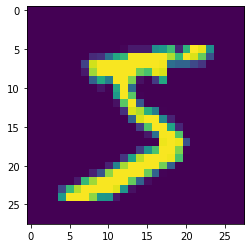

In [5]:
import matplotlib.pyplot as plt

plt.imshow(dataset.data[0].detach().numpy())
plt.show()

Обучить полносвязную модель на MNIST


In [6]:
class LinearModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, output_dim)
    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activation(self.linear1(x)))
    x = self.do2(self.activation(self.linear2(x)))

    return self.linear3(x)

In [7]:
def collate_fn(data: list):
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.view(pics.size(0), -1),
      'target': target,
      }

In [8]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [9]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [10]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device).long())
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  torch.save(model.state_dict(), f'./chkpt_{epoch}.pth')

epoch: 0, step: 0, loss: 2.3080387115478516
epoch: 0, step: 200, loss: 0.27142202854156494
epoch: 0, step: 400, loss: 0.16047275066375732
epoch: 1, step: 0, loss: 0.3296003043651581
epoch: 1, step: 200, loss: 0.13499540090560913
epoch: 1, step: 400, loss: 0.14549976587295532
epoch: 2, step: 0, loss: 0.0952591523528099
epoch: 2, step: 200, loss: 0.05599898472428322
epoch: 2, step: 400, loss: 0.052421946078538895
epoch: 3, step: 0, loss: 0.10020409524440765
epoch: 3, step: 200, loss: 0.09225805848836899
epoch: 3, step: 400, loss: 0.05991232395172119
epoch: 4, step: 0, loss: 0.026445476338267326
epoch: 4, step: 200, loss: 0.036446042358875275
epoch: 4, step: 400, loss: 0.0992339476943016
epoch: 5, step: 0, loss: 0.03642643988132477
epoch: 5, step: 200, loss: 0.018583180382847786
epoch: 5, step: 400, loss: 0.042029984295368195
epoch: 6, step: 0, loss: 0.03233757242560387
epoch: 6, step: 200, loss: 0.051398344337940216
epoch: 6, step: 400, loss: 0.04147714748978615
epoch: 7, step: 0, loss: 

Обучить глубокую сверточную сеть на MNIST


In [11]:
class ConvModel(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, 
                           kernel_size=5, padding=2, stride=2) # уменьшаем картинку в 2 раза
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.conv3 = nn.Conv2d(hidden_ch, 2, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(2)
    self.linear3 = nn.Linear(2 * 14 * 14, output_dim)
    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activation(self.bn1(self.conv1(x))))
    x = self.do2(self.activation(self.bn2(self.conv2(x))))
    x = self.activation(self.bn3(self.conv3(x))) # B x 2 x 14 x 14

    return self.linear3(x.view(x.size(0), -1))
    # x.size() -> (B, W, H); x.size(0) -> B
    # x.view(B, -1) -> (B, вектор размера всего остального)

In [16]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [17]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [18]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [19]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model_conv(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device))
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  torch.save(model_conv.state_dict(), f'./chkpt_conv_{epoch}.pth')

epoch: 0, step: 0, loss: 2.3839478492736816
epoch: 0, step: 200, loss: 0.23991021513938904
epoch: 0, step: 400, loss: 0.0788557380437851
epoch: 1, step: 0, loss: 0.050048645585775375
epoch: 1, step: 200, loss: 0.05390132963657379
epoch: 1, step: 400, loss: 0.04379330202937126
epoch: 2, step: 0, loss: 0.01650567166507244
epoch: 2, step: 200, loss: 0.0698031634092331
epoch: 2, step: 400, loss: 0.02215498685836792
epoch: 3, step: 0, loss: 0.042865339666604996
epoch: 3, step: 200, loss: 0.05103715881705284
epoch: 3, step: 400, loss: 0.017411179840564728
epoch: 4, step: 0, loss: 0.0862845852971077
epoch: 4, step: 200, loss: 0.046976275742053986
epoch: 4, step: 400, loss: 0.09513327479362488
epoch: 5, step: 0, loss: 0.038290832191705704
epoch: 5, step: 200, loss: 0.023012474179267883
epoch: 5, step: 400, loss: 0.0323031023144722
epoch: 6, step: 0, loss: 0.02410324662923813
epoch: 6, step: 200, loss: 0.009010766632854939
epoch: 6, step: 400, loss: 0.027008259668946266
epoch: 7, step: 0, loss: